In [1]:
import pandas as pd
import ast
from scipy.stats import norm
import numpy as np
import sklearn.metrics #import precision_score, recall_score, f1_score
from confidenceinterval import precision_score, recall_score, f1_score
from confidenceinterval import classification_report_with_ci

# Abstract level evaluation

In [1014]:
annotated_files_path_prefix = "./predictions/rebuttal/"
annotated_files_path_suffix = "20240529"
path_to_test_set = "../data/annotated_data/data_splits/stratified_entities/ct_neuro_test_merged_153.csv"
path_to_all_annotations = "./predictions/rebuttal/all_models_aggregated_all_entity_types_numarical_arrays.csv"


In [1015]:
test_set = pd.read_csv(path_to_test_set)

In [1016]:
annotations_df = pd.read_csv(path_to_all_annotations)
annotations_df.shape

(153, 280)

In [1017]:
annotations_df.head()

,Unnamed: 0,nct_id,unique_condition_regex,unique_drug_regex,unique_condition_target,unique_drug_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,...,target_drug_v1_annotations_partial_gpt-4,predicted_drug_v1_annotations_partial_gpt-4,target_drug_v2_annotations_exact_gpt-3.5-turbo,predicted_drug_v2_annotations_exact_gpt-3.5-turbo,target_drug_v2_annotations_partial_gpt-3.5-turbo,predicted_drug_v2_annotations_partial_gpt-3.5-turbo,target_drug_v2_annotations_exact_gpt-4,predicted_drug_v2_annotations_exact_gpt-4,target_drug_v2_annotations_partial_gpt-4,predicted_drug_v2_annotations_partial_gpt-4
0,0,NCT04045665,NaN,NaN,coronary artery bypass graft|isolated coronary...,anticoagulants|anticoagulation|antiplatelet th...,NaN,NaN,NaN,NaN,...,"[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
1,1,NCT02311036,NaN,NaN,-cerebrovascular diseases,NaN,NaN,comprehensive rehabilitation,NaN,NaN,...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2,2,NCT05369793,diabetic neuropathy,roflumilast,diabetic neuropathy|type 2 diabetic,roflumilast,NaN,NaN,NaN,NaN,...,[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]
3,3,NCT04483310,paralyses|narcolepsy|sleep paralysis,aim,narcolepsy|sleep paralyses|sleep paralysis,NaN,sham,NaN,meditation relaxation therapy|meditation-relax...,NaN,...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
4,4,NCT01418976,brain injury,balance,"chronic, mild-to-moderate, traumatic brain inj...",NaN,NaN,intensive mobility training,NaN,NaN,...,[0],[0],[0],[0],[0],[0],[0],[1],[0],[1]


In [1018]:
annotations_df.columns

Index(['Unnamed: 0', 'nct_id', 'unique_condition_regex', 'unique_drug_regex',
       'unique_condition_target', 'unique_drug_target',
       'unique_control_target', 'unique_physical_target',
       'unique_behavioural_target', 'unique_surgical_target',
       ...
       'target_drug_v1_annotations_partial_gpt-4',
       'predicted_drug_v1_annotations_partial_gpt-4',
       'target_drug_v2_annotations_exact_gpt-3.5-turbo',
       'predicted_drug_v2_annotations_exact_gpt-3.5-turbo',
       'target_drug_v2_annotations_partial_gpt-3.5-turbo',
       'predicted_drug_v2_annotations_partial_gpt-3.5-turbo',
       'target_drug_v2_annotations_exact_gpt-4',
       'predicted_drug_v2_annotations_exact_gpt-4',
       'target_drug_v2_annotations_partial_gpt-4',
       'predicted_drug_v2_annotations_partial_gpt-4'],
      dtype='object', length=280)

## Prep Evaluations

In [1019]:
from confidenceinterval import precision_score, recall_score, f1_score
import sklearn.metrics

In [1020]:
def flatten_column_arrays(column):
    # Prepare an array to hold the actual arrays/lists
    prepared_arrays = []
    
    for item in column:
        if isinstance(item, str):
            try:
                # Safely evaluate the string to see if it represents a list
                evaluated_item = ast.literal_eval(item)
                if isinstance(evaluated_item, list):
                    prepared_arrays.append(np.array(evaluated_item))
            except (SyntaxError, ValueError):
                # If evaluation fails or it's not a list, skip or handle non-list string
                print("Not possible to flatten ", item)
                continue
        elif isinstance(item, list):
            prepared_arrays.append(np.array(item))
        elif isinstance(item, np.ndarray):
            prepared_test_arrays.append(item)
    
    if prepared_arrays:
        # Concatenate all arrays in the list and then flatten the result
        return np.concatenate(prepared_arrays).flatten()
    else:
        return np.array([])  # Return an empty array if no valid arrays were found


In [1021]:
def round_tuple(input_tuple, decimals=2):
    rounded_elements = []
    for item in input_tuple:
        if isinstance(item, tuple):
            rounded_elements.append(round_tuple(item, decimals))
        else:
            rounded_elements.append(round(item, decimals))
    return tuple(rounded_elements)

### Select GPT drug/cond column to use (experimented with 2 prompt versions)

In [1022]:
entities = ['condition_v1', 'condition_v2', 'drug_v1', 'drug_v2']
models = ['gpt-3.5-turbo', 'gpt-4']

def calculate_exact_and_partial_match_scores(annotations_df, entities, models, round_to=2):
    exact_matches = {}
    partial_matches = {}
    
    for entity in entities:
        exact_matches[entity] = {}
        partial_matches[entity] = {}
    
        for model in models:
            if (entity != 'condition' and entity != 'drug') and 'regex' in model:
               continue  
            try:
                 # Check if all columns are present in the DataFrame
                # Columns to check
                columns_to_check = [f'target_{entity}_annotations_exact_{model}',
                                    f'predicted_{entity}_annotations_exact_{model}',
                                    f'target_{entity}_annotations_partial_{model}',
                                    f'predicted_{entity}_annotations_partial_{model}']
                
                # Check if all columns are present in the DataFrame
                missing_columns = [col for col in columns_to_check if col not in annotations_df.columns]
                if not missing_columns:
                    flattened_data_target_exact = flatten_column_arrays(annotations_df[f'target_{entity}_annotations_exact_{model}'])
                    flattened_data_model_exact = flatten_column_arrays(annotations_df[f'predicted_{entity}_annotations_exact_{model}'])
                    flattened_data_target_partial = flatten_column_arrays(annotations_df[f'target_{entity}_annotations_partial_{model}'])
                    flattened_data_model_partial = flatten_column_arrays(annotations_df[f'predicted_{entity}_annotations_partial_{model}'])
                else:
                    # Handle the case where one or more columns are missing
                    print("The following required columns are missing in the DataFrame:")
                    for col in missing_columns:
                        print(col)
        
                flattened_data_target_exact = flatten_column_arrays(annotations_df.get(f'target_{entity}_annotations_exact_{model}', pd.Series()))
                flattened_data_model_exact = flatten_column_arrays(annotations_df.get(f'predicted_{entity}_annotations_exact_{model}', pd.Series()))
                flattened_data_target_partial = flatten_column_arrays(annotations_df.get(f'target_{entity}_annotations_partial_{model}', pd.Series()))
                flattened_data_model_partial = flatten_column_arrays(annotations_df.get(f'predicted_{entity}_annotations_partial_{model}', pd.Series()))
    
                # Calculate and store F1 scores
                exact_f1 = f1_score(flattened_data_target_exact, flattened_data_model_exact, average='binary')
                partial_f1 = f1_score(flattened_data_target_partial, flattened_data_model_partial, average='binary')
    
                exact_matches[entity][model] = round_tuple(exact_f1,round_to)
                partial_matches[entity][model] = round_tuple(partial_f1,round_to)
    
            except Exception as e:
                print(f"An error occurred for {model} in {entity}: {e}")
    return exact_matches, partial_matches


In [1023]:
exact_matches, partial_matches = calculate_exact_and_partial_match_scores(annotations_df, entities, models)
partial_matches

{'condition_v1': {'gpt-3.5-turbo': (0.62, (0.58, 0.66)),
  'gpt-4': (0.77, (0.73, 0.81))},
 'condition_v2': {'gpt-3.5-turbo': (0.63, (0.59, 0.66)),
  'gpt-4': (0.73, (0.69, 0.77))},
 'drug_v1': {'gpt-3.5-turbo': (0.4, (0.34, 0.47)),
  'gpt-4': (0.78, (0.71, 0.84))},
 'drug_v2': {'gpt-3.5-turbo': (0.66, (0.59, 0.74)),
  'gpt-4': (0.71, (0.65, 0.78))}}

In [1024]:
df_exact = pd.DataFrame(exact_matches)
df_exact.T

,gpt-3.5-turbo,gpt-4
condition_v1,"(0.44, (0.39, 0.49))","(0.57, (0.53, 0.62))"
condition_v2,"(0.45, (0.41, 0.49))","(0.53, (0.49, 0.58))"
drug_v1,"(0.35, (0.29, 0.42))","(0.67, (0.6, 0.75))"
drug_v2,"(0.57, (0.48, 0.65))","(0.56, (0.48, 0.64))"


NOTE: will keep v2 for gpt-3.5 and v1 for gpt-4

In [1025]:
annotations_df_final = annotations_df.rename(columns = {
                                 "unique_drug_v2_gpt-3.5-turbo": "unique_drug_gpt-3.5-turbo",
                                 "unique_condition_v2_gpt-3.5-turbo": "unique_condition_gpt-3.5-turbo",
                                 "unique_drug_v1_gpt-4": "unique_drug_gpt-4",
                                 "unique_condition_v1_gpt-4": "unique_condition_gpt-4",

                                 "target_condition_v2_annotations_exact_gpt-3.5-turbo": "target_condition_annotations_exact_gpt-3.5-turbo",
                                 "target_condition_v2_annotations_partial_gpt-3.5-turbo": "target_condition_annotations_partial_gpt-3.5-turbo",
                                 "target_drug_v2_annotations_exact_gpt-3.5-turbo": "target_drug_annotations_exact_gpt-3.5-turbo",
                                 "target_drug_v2_annotations_partial_gpt-3.5-turbo": "target_drug_annotations_partial_gpt-3.5-turbo",
    
                                 "target_condition_v1_annotations_exact_gpt-4": "target_condition_annotations_exact_gpt-4",
                                 "target_condition_v1_annotations_partial_gpt-4": "target_condition_annotations_partial_gpt-4",
                                 "target_drug_v1_annotations_exact_gpt-4": "target_drug_annotations_exact_gpt-4",
                                 "target_drug_v1_annotations_partial_gpt-4": "target_drug_annotations_partial_gpt-4",
    
                                 "predicted_condition_v2_annotations_exact_gpt-3.5-turbo": "predicted_condition_annotations_exact_gpt-3.5-turbo",
                                 "predicted_condition_v2_annotations_partial_gpt-3.5-turbo": "predicted_condition_annotations_partial_gpt-3.5-turbo",
                                 "predicted_drug_v2_annotations_exact_gpt-3.5-turbo": "predicted_drug_annotations_exact_gpt-3.5-turbo",
                                 "predicted_drug_v2_annotations_partial_gpt-3.5-turbo": "predicted_drug_annotations_partial_gpt-3.5-turbo",
    
                                 "predicted_condition_v1_annotations_exact_gpt-4": "predicted_condition_annotations_exact_gpt-4",
                                 "predicted_condition_v1_annotations_partial_gpt-4": "predicted_condition_annotations_partial_gpt-4",
                                 "predicted_drug_v1_annotations_exact_gpt-4": "predicted_drug_annotations_exact_gpt-4",
                                 "predicted_drug_v1_annotations_partial_gpt-4": "predicted_drug_annotations_partial_gpt-4"
                                                       })

## Prepare output for error analysis

In [1026]:
annotations_df_final.head()

,Unnamed: 0,nct_id,unique_condition_regex,unique_drug_regex,unique_condition_target,unique_drug_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,...,target_drug_annotations_partial_gpt-4,predicted_drug_annotations_partial_gpt-4,target_drug_annotations_exact_gpt-3.5-turbo,predicted_drug_annotations_exact_gpt-3.5-turbo,target_drug_annotations_partial_gpt-3.5-turbo,predicted_drug_annotations_partial_gpt-3.5-turbo,target_drug_v2_annotations_exact_gpt-4,predicted_drug_v2_annotations_exact_gpt-4,target_drug_v2_annotations_partial_gpt-4,predicted_drug_v2_annotations_partial_gpt-4
0,0,NCT04045665,NaN,NaN,coronary artery bypass graft|isolated coronary...,anticoagulants|anticoagulation|antiplatelet th...,NaN,NaN,NaN,NaN,...,"[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
1,1,NCT02311036,NaN,NaN,-cerebrovascular diseases,NaN,NaN,comprehensive rehabilitation,NaN,NaN,...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2,2,NCT05369793,diabetic neuropathy,roflumilast,diabetic neuropathy|type 2 diabetic,roflumilast,NaN,NaN,NaN,NaN,...,[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]
3,3,NCT04483310,paralyses|narcolepsy|sleep paralysis,aim,narcolepsy|sleep paralyses|sleep paralysis,NaN,sham,NaN,meditation relaxation therapy|meditation-relax...,NaN,...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
4,4,NCT01418976,brain injury,balance,"chronic, mild-to-moderate, traumatic brain inj...",NaN,NaN,intensive mobility training,NaN,NaN,...,[0],[0],[0],[0],[0],[0],[0],[1],[0],[1]


In [1027]:
test_set.head(2)

,tokens,ner_tags,id,nct_id,text,ner_manual_ct_target
0,"['A', 'Prospective', ',', 'Double', '-', 'blin...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",NCT05850585,NCT05850585,"A Prospective, Double-blind, Randomized Contro...","[(60, 63, 'OTHER', 'FMT'), (78, 91, 'DRUG', 'A..."
1,"['Virtual', 'Reality', 'Augmented', 'Gait', 'A...","['B-OTHER', 'I-OTHER', 'I-OTHER', 'I-OTHER', '...",NCT03787693,NCT03787693,Virtual Reality Augmented Gait Adaptation in S...,"[(0, 41, 'OTHER', 'Virtual Reality Augmented G..."


In [1028]:
# Function to combine values of related columns into a single column
def combine_values(row, prefixes, suffixes):
    combined = []
    for prefix in prefixes:
        for suffix in suffixes:
            if (prefix != 'unique_condition' and prefix != 'unique_drug') and 'regex' in suffix:
                continue
            col_name = f'{prefix}_{suffix}'
            values = row[col_name]
            if isinstance(values, str) and values.strip():  # Check if values is a non-empty string
                combined.append(f"{prefix}: {'|'.join(values.split('|'))}")
    return ', \n'.join(combined) if combined else pd.NA
      
# List of prefixes for related columns
prefixes = ['unique_condition', 'unique_drug', 'unique_control', 'unique_physical', 'unique_behavioural', 'unique_surgical', 'unique_radiotherapy', 'unique_other']

# List of suffixes for related columns
suffixes = ['target', 'BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased', 'gpt-4', 'gpt-3.5-turbo', 'aact', 'regex']

# Create new DataFrame to store combined columns
combined_df = annotations_df_final.copy()[['nct_id']]

# Create new columns with combined values
for suffix in suffixes:
    combined_df[f'combined_all_{suffix}'] = annotations_df_final.apply(lambda row: combine_values(row, prefixes, [suffix]), axis=1)

combined_df.head(3)

,nct_id,combined_all_target,combined_all_BioLinkBERT-base,combined_all_biobert-v1.1,combined_all_bert-base-uncased,combined_all_gpt-4,combined_all_gpt-3.5-turbo,combined_all_aact,combined_all_regex
0,NCT04045665,unique_condition: coronary artery bypass graft...,unique_condition: cabg) surgery|coronary arter...,unique_condition: cabg) surgery|coronary arter...,unique_condition: coronary artery bypass graft...,unique_condition: atrial fibrillation|coronary...,unique_condition: atrial fibrillation|thromboe...,unique_condition: stroke|bleeding|atrial fibri...,<NA>
1,NCT02311036,"unique_condition: -cerebrovascular diseases, \...",unique_condition: post-acute care-cerebrovascu...,unique_condition: post-acute care-cerebrovascu...,unique_condition: post-acute care-cerebrovascu...,unique_condition: cerebrovascular diseases,unique_condition: none|cerebrovascular diseases,"unique_condition: cerebrovascular diseases, \n...",<NA>
2,NCT05369793,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: type 2 diabetes (adult onset...,"unique_condition: diabetic neuropathy, \nuniqu..."


In [1029]:
# Entities and models
entities = ['condition', 'other', 'drug', 'physical', 'behavioural', 'surgical', 'radiotherapy', 'control']
models = ['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased', 'gpt-4', 'gpt-3.5-turbo', 'aact', 'regex']

# Function to calculate F1 scores for each entity and model combination
def calculate_entity_model_f1(row, entity, model):
    target_exact_col = f'target_{entity}_annotations_exact_{model}'
    predicted_exact_col = f'predicted_{entity}_annotations_exact_{model}'
    target_partial_col = f'target_{entity}_annotations_partial_{model}'
    predicted_partial_col = f'predicted_{entity}_annotations_partial_{model}'
    
    target_exact = row[target_exact_col]
    predicted_exact = row[predicted_exact_col]
    target_partial = row[target_partial_col]
    predicted_partial = row[predicted_partial_col]

    # Convert string representation of list to actual list
    target_exact = ast.literal_eval(row[target_exact_col])
    predicted_exact = ast.literal_eval(row[predicted_exact_col])
    target_partial = ast.literal_eval(row[target_partial_col])
    predicted_partial = ast.literal_eval(row[predicted_partial_col])
    
    # Calculate F1 scores
    #print(target_exact, predicted_exact)
    exact_f1 = sklearn.metrics.f1_score(target_exact, predicted_exact, zero_division=0)
    partial_f1 = sklearn.metrics.f1_score(target_partial, predicted_partial, zero_division=0)
    
    return exact_f1, partial_f1

# Calculate F1 scores for each entity and model combination for each row
for entity in entities:
    for model in models:
        if (entity != 'condition' and entity != 'drug') and 'regex' in model:
            continue
        exact_f1_col = f'{entity}_exact_f1_{model}'
        partial_f1_col = f'{entity}_partial_f1_{model}'
        combined_df[[exact_f1_col, partial_f1_col]] = annotations_df_final.apply(lambda row: calculate_entity_model_f1(row, entity, model), axis=1, result_type='expand')


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_76223/1321105962.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[[exact_f1_col, partial_f1_col]] = annotations_df_final.apply(lambda row: calculate_entity_model_f1(row, entity, model), axis=1, result_type='expand')
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_76223/1321105962.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[[exact_f1_col, partial_f1_col]] = annotations_df_final.apply(lambda row: calculate_entity_model_f1(row

In [1030]:
combined_df_with_text = combined_df.merge(test_set[['nct_id', 'text']], on='nct_id')
combined_df_with_text.head(2)

,nct_id,combined_all_target,combined_all_BioLinkBERT-base,combined_all_biobert-v1.1,combined_all_bert-base-uncased,combined_all_gpt-4,combined_all_gpt-3.5-turbo,combined_all_aact,combined_all_regex,condition_exact_f1_BioLinkBERT-base,...,control_partial_f1_biobert-v1.1,control_exact_f1_bert-base-uncased,control_partial_f1_bert-base-uncased,control_exact_f1_gpt-4,control_partial_f1_gpt-4,control_exact_f1_gpt-3.5-turbo,control_partial_f1_gpt-3.5-turbo,control_exact_f1_aact,control_partial_f1_aact,text
0,NCT04045665,unique_condition: coronary artery bypass graft...,unique_condition: cabg) surgery|coronary arter...,unique_condition: cabg) surgery|coronary arter...,unique_condition: coronary artery bypass graft...,unique_condition: atrial fibrillation|coronary...,unique_condition: atrial fibrillation|thromboe...,unique_condition: stroke|bleeding|atrial fibri...,<NA>,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anticoagulation for New-Onset Post-Operative A...
1,NCT02311036,"unique_condition: -cerebrovascular diseases, \...",unique_condition: post-acute care-cerebrovascu...,unique_condition: post-acute care-cerebrovascu...,unique_condition: post-acute care-cerebrovascu...,unique_condition: cerebrovascular diseases,unique_condition: none|cerebrovascular diseases,"unique_condition: cerebrovascular diseases, \n...",<NA>,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Effect and Outcome Predictors on Functional Re...


In [1031]:
biobert_columns = combined_df_with_text.filter(like='biobert-v1.1').columns.tolist()
col_of_interest = ['nct_id', 'combined_all_target'] + biobert_columns
df_biobert = combined_df_with_text[col_of_interest]

In [1032]:
sampled_dfs = []
for entity in entities:
    exact_f1_col = f'{entity}_exact_f1_biobert-v1.1'
    partial_f1_col = f'{entity}_partial_f1_biobert-v1.1'
    filtered_df = df_biobert[df_biobert[exact_f1_col] < df_biobert[partial_f1_col]]
    count_entity_rows = df_biobert[df_biobert['combined_all_target'].str.contains(entity, case=False, na=False)].shape[0]

    print(f"{entity} non-equal exact and partial {len(filtered_df)} out of {count_entity_rows} ({len(filtered_df)/count_entity_rows})")
    
    if not filtered_df.empty:
        sampled_df = filtered_df.sample(15, replace=True, random_state=33)  # Using replace=True because the sample size might be larger than the available rows
        sampled_df['entity_type'] = entity
        sampled_dfs.append(sampled_df)

if sampled_dfs:
    result_df = pd.concat(sampled_dfs)
else:
    result_df = pd.DataFrame()

condition non-equal exact and partial 40 out of 144 (0.2777777777777778)
other non-equal exact and partial 21 out of 55 (0.38181818181818183)
drug non-equal exact and partial 13 out of 51 (0.2549019607843137)
physical non-equal exact and partial 16 out of 36 (0.4444444444444444)
behavioural non-equal exact and partial 9 out of 23 (0.391304347826087)
surgical non-equal exact and partial 4 out of 12 (0.3333333333333333)
radiotherapy non-equal exact and partial 1 out of 5 (0.2)
control non-equal exact and partial 14 out of 47 (0.2978723404255319)


In [1033]:
result_df.to_csv("./predictions/rebuttal/all_models_aggregated_annotations_for_REVIEW_BioBERT_samples.csv")

In [1034]:
df_biobert.head()

,nct_id,combined_all_target,combined_all_biobert-v1.1,condition_exact_f1_biobert-v1.1,condition_partial_f1_biobert-v1.1,other_exact_f1_biobert-v1.1,other_partial_f1_biobert-v1.1,drug_exact_f1_biobert-v1.1,drug_partial_f1_biobert-v1.1,physical_exact_f1_biobert-v1.1,physical_partial_f1_biobert-v1.1,behavioural_exact_f1_biobert-v1.1,behavioural_partial_f1_biobert-v1.1,surgical_exact_f1_biobert-v1.1,surgical_partial_f1_biobert-v1.1,radiotherapy_exact_f1_biobert-v1.1,radiotherapy_partial_f1_biobert-v1.1,control_exact_f1_biobert-v1.1,control_partial_f1_biobert-v1.1
0,NCT04045665,unique_condition: coronary artery bypass graft...,unique_condition: cabg) surgery|coronary arter...,0.60,0.833333,0.0,0.0,0.444444,0.923077,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCT02311036,"unique_condition: -cerebrovascular diseases, \...",unique_condition: post-acute care-cerebrovascu...,0.00,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCT05369793,unique_condition: diabetic neuropathy|type 2 d...,unique_condition: diabetic neuropathy|type 2 d...,1.00,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCT04483310,unique_condition: narcolepsy|sleep paralyses|s...,unique_condition: narcolepsy|sleep paralyses|s...,1.00,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.666667,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,NCT01418976,"unique_condition: chronic, mild-to-moderate, t...","unique_condition: chronic , mild-to-moderate ,...",0.25,0.727273,0.0,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1035]:
df_biobert.to_csv("./predictions/rebuttal/all_models_aggregated_annotations_for_REVIEW_BioBERT.csv")

In [1036]:
combined_df_with_text.to_csv("./predictions/rebuttal/all_models_aggregated_annotations_for_REVIEW.csv")

## Evaluate all models on abstract level

In [1037]:
entities = ['condition', 'other', 'drug', 'physical', 'behavioural', 'surgical', 'radiotherapy', 'control']
models = ['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased', 'gpt-4', 'gpt-3.5-turbo', 'aact','regex']

exact_matches, partial_matches = calculate_exact_and_partial_match_scores(annotations_df_final, entities, models)

In [1038]:
df_exact_all = pd.DataFrame(exact_matches)
df_exact_all_transposed = df_exact_all.T
df_exact_all_transposed['regex'] = df_exact_all_transposed['regex'].fillna('(n.a.)')

df_exact_all_transposed.reset_index(inplace=True)
df_exact_all_transposed.rename(columns={'index': 'Entity Type'}, inplace=True)
df_exact_all_transposed['Entity Type'] = df_exact_all_transposed['Entity Type'].str.upper()
df_exact_all_transposed.iloc[:, 1:] = df_exact_all_transposed.iloc[:, 1:].map(lambda x: str(x)[1:-1])

df_exact_all_transposed

,Entity Type,BioLinkBERT-base,biobert-v1.1,bert-base-uncased,gpt-4,gpt-3.5-turbo,aact,regex
0,CONDITION,"0.77, (0.73, 0.81)","0.72, (0.68, 0.76)","0.61, (0.57, 0.65)","0.57, (0.53, 0.62)","0.45, (0.41, 0.49)","0.25, (0.2, 0.29)","0.34, (0.28, 0.4)"
1,OTHER,"0.39, (0.33, 0.46)","0.47, (0.4, 0.55)","0.28, (0.21, 0.34)","0.15, (0.09, 0.2)","0.09, (0.04, 0.14)","0.05, (0.01, 0.1)",n.a.
2,DRUG,"0.82, (0.76, 0.89)","0.72, (0.65, 0.79)","0.53, (0.45, 0.61)","0.67, (0.6, 0.75)","0.57, (0.48, 0.65)","0.44, (0.35, 0.53)","0.33, (0.26, 0.41)"
3,PHYSICAL,"0.41, (0.31, 0.5)","0.45, (0.35, 0.55)","0.41, (0.32, 0.5)","0.14, (0.07, 0.2)","0.11, (0.05, 0.17)","0.03, (-0.03, 0.08)",n.a.
4,BEHAVIOURAL,"0.32, (0.21, 0.42)","0.5, (0.38, 0.61)","0.22, (0.11, 0.34)","0.07, (0.01, 0.13)","0.04, (-0.0, 0.09)","0.02, (-0.02, 0.05)",n.a.
5,SURGICAL,"0.09, (-0.03, 0.22)","0.44, (0.29, 0.59)","0.08, (-0.03, 0.19)","0.09, (-0.01, 0.2)","0.11, (0.03, 0.19)","0.0, (0.0, 0.0)",n.a.
6,RADIOTHERAPY,"0.0, (0.0, 0.0)","0.8, (0.58, 1.02)","0.0, (0.0, 0.0)","0.13, (-0.11, 0.37)","0.05, (-0.02, 0.12)","0.13, (-0.11, 0.37)",n.a.
7,CONTROL,"0.69, (0.59, 0.78)","0.58, (0.49, 0.68)","0.05, (-0.02, 0.12)","0.4, (0.3, 0.5)","0.22, (0.14, 0.3)","0.3, (0.18, 0.43)",n.a.


### To LaTeX

In [1039]:
print(df_exact_all_transposed.to_latex(float_format="%.3f", index=False))

\begin{tabular}{llllllll}
\toprule
Entity Type & BioLinkBERT-base & biobert-v1.1 & bert-base-uncased & gpt-4 & gpt-3.5-turbo & aact & regex \\
\midrule
CONDITION & 0.77, (0.73, 0.81) & 0.72, (0.68, 0.76) & 0.61, (0.57, 0.65) & 0.57, (0.53, 0.62) & 0.45, (0.41, 0.49) & 0.25, (0.2, 0.29) & 0.34, (0.28, 0.4) \\
OTHER & 0.39, (0.33, 0.46) & 0.47, (0.4, 0.55) & 0.28, (0.21, 0.34) & 0.15, (0.09, 0.2) & 0.09, (0.04, 0.14) & 0.05, (0.01, 0.1) & n.a. \\
DRUG & 0.82, (0.76, 0.89) & 0.72, (0.65, 0.79) & 0.53, (0.45, 0.61) & 0.67, (0.6, 0.75) & 0.57, (0.48, 0.65) & 0.44, (0.35, 0.53) & 0.33, (0.26, 0.41) \\
PHYSICAL & 0.41, (0.31, 0.5) & 0.45, (0.35, 0.55) & 0.41, (0.32, 0.5) & 0.14, (0.07, 0.2) & 0.11, (0.05, 0.17) & 0.03, (-0.03, 0.08) & n.a. \\
BEHAVIOURAL & 0.32, (0.21, 0.42) & 0.5, (0.38, 0.61) & 0.22, (0.11, 0.34) & 0.07, (0.01, 0.13) & 0.04, (-0.0, 0.09) & 0.02, (-0.02, 0.05) & n.a. \\
SURGICAL & 0.09, (-0.03, 0.22) & 0.44, (0.29, 0.59) & 0.08, (-0.03, 0.19) & 0.09, (-0.01, 0.2) & 0.11, (0.

In [1040]:
df_partial_all = pd.DataFrame(partial_matches)
df_partial_all_transposed = df_partial_all.T
df_partial_all_transposed['regex'] = df_partial_all_transposed['regex'].fillna('(n.a.)')

df_partial_all_transposed.reset_index(inplace=True)
df_partial_all_transposed.rename(columns={'index': 'Entity Type'}, inplace=True)
df_partial_all_transposed['Entity Type'] = df_partial_all_transposed['Entity Type'].str.upper()
df_partial_all_transposed.iloc[:, 1:] = df_partial_all_transposed.iloc[:, 1:].map(lambda x: str(x)[1:-1])

df_partial_all_transposed

,Entity Type,BioLinkBERT-base,biobert-v1.1,bert-base-uncased,gpt-4,gpt-3.5-turbo,aact,regex
0,CONDITION,"0.85, (0.82, 0.89)","0.85, (0.81, 0.88)","0.72, (0.68, 0.75)","0.77, (0.73, 0.81)","0.63, (0.59, 0.66)","0.57, (0.53, 0.61)","0.5, (0.44, 0.55)"
1,OTHER,"0.62, (0.56, 0.67)","0.73, (0.67, 0.8)","0.55, (0.5, 0.6)","0.4, (0.34, 0.45)","0.33, (0.27, 0.4)","0.36, (0.29, 0.44)",n.a.
2,DRUG,"0.91, (0.86, 0.96)","0.87, (0.81, 0.92)","0.75, (0.68, 0.81)","0.78, (0.71, 0.84)","0.66, (0.59, 0.74)","0.63, (0.55, 0.71)","0.4, (0.33, 0.47)"
3,PHYSICAL,"0.71, (0.64, 0.79)","0.74, (0.66, 0.82)","0.72, (0.65, 0.79)","0.38, (0.31, 0.45)","0.39, (0.32, 0.46)","0.1, (-0.0, 0.2)",n.a.
4,BEHAVIOURAL,"0.68, (0.6, 0.77)","0.77, (0.69, 0.85)","0.46, (0.34, 0.57)","0.38, (0.3, 0.46)","0.32, (0.24, 0.41)","0.27, (0.17, 0.36)",n.a.
5,SURGICAL,"0.29, (0.12, 0.46)","0.69, (0.57, 0.81)","0.41, (0.25, 0.57)","0.52, (0.39, 0.65)","0.24, (0.14, 0.33)","0.0, (0.0, 0.0)",n.a.
6,RADIOTHERAPY,"0.0, (0.0, 0.0)","0.88, (0.7, 1.05)","0.0, (0.0, 0.0)","0.67, (0.43, 0.9)","0.07, (-0.02, 0.16)","0.35, (0.06, 0.65)",n.a.
7,CONTROL,"0.85, (0.78, 0.92)","0.84, (0.77, 0.91)","0.68, (0.58, 0.77)","0.64, (0.55, 0.72)","0.49, (0.41, 0.57)","0.42, (0.3, 0.54)",n.a.


In [1041]:
print(df_partial_all_transposed.to_latex(float_format="%.3f", index=False))

\begin{tabular}{llllllll}
\toprule
Entity Type & BioLinkBERT-base & biobert-v1.1 & bert-base-uncased & gpt-4 & gpt-3.5-turbo & aact & regex \\
\midrule
CONDITION & 0.85, (0.82, 0.89) & 0.85, (0.81, 0.88) & 0.72, (0.68, 0.75) & 0.77, (0.73, 0.81) & 0.63, (0.59, 0.66) & 0.57, (0.53, 0.61) & 0.5, (0.44, 0.55) \\
OTHER & 0.62, (0.56, 0.67) & 0.73, (0.67, 0.8) & 0.55, (0.5, 0.6) & 0.4, (0.34, 0.45) & 0.33, (0.27, 0.4) & 0.36, (0.29, 0.44) & n.a. \\
DRUG & 0.91, (0.86, 0.96) & 0.87, (0.81, 0.92) & 0.75, (0.68, 0.81) & 0.78, (0.71, 0.84) & 0.66, (0.59, 0.74) & 0.63, (0.55, 0.71) & 0.4, (0.33, 0.47) \\
PHYSICAL & 0.71, (0.64, 0.79) & 0.74, (0.66, 0.82) & 0.72, (0.65, 0.79) & 0.38, (0.31, 0.45) & 0.39, (0.32, 0.46) & 0.1, (-0.0, 0.2) & n.a. \\
BEHAVIOURAL & 0.68, (0.6, 0.77) & 0.77, (0.69, 0.85) & 0.46, (0.34, 0.57) & 0.38, (0.3, 0.46) & 0.32, (0.24, 0.41) & 0.27, (0.17, 0.36) & n.a. \\
SURGICAL & 0.29, (0.12, 0.46) & 0.69, (0.57, 0.81) & 0.41, (0.25, 0.57) & 0.52, (0.39, 0.65) & 0.24, (0.14, 0

### Viz

In [1042]:
import matplotlib.pyplot as plt

In [1043]:
target_path = "../data/annotated_data/corpus_stats/stratified_entities/"

In [1044]:
dev_entities = pd.read_csv(target_path + "clintrials_dev_entities_stats.csv")
train_entities = pd.read_csv(target_path + "clintrials_train_entities_stats.csv")
test_entities = pd.read_csv(target_path + "clintrials_test_entities_stats.csv")

In [1045]:
dev_entities.head()

,entity_token,frequency,entity_class
0,stroke,42,CONDITION
1,placebo,21,CONTROL
2,dementia,20,CONDITION
3,pain,19,CONDITION
4,pd,19,CONDITION


In [1046]:
grouped_df_train = train_entities.groupby('entity_class')['frequency'].sum()
grouped_df_train = grouped_df_train.sort_values(ascending=False)
grouped_df_train

entity_class
CONDITION       3524
OTHER           1361
DRUG            1205
CONTROL          396
PHYSICAL         326
BEHAVIOURAL      156
SURGICAL          83
RADIOTHERAPY      30
Name: frequency, dtype: int64

In [1047]:
grouped_df_test = test_entities.groupby('entity_class')['frequency'].sum()
grouped_df_test = grouped_df_test.sort_values(ascending=False)
grouped_df_test

entity_class
CONDITION       683
DRUG            213
OTHER           167
PHYSICAL        130
BEHAVIOURAL      91
CONTROL          84
SURGICAL         54
RADIOTHERAPY     22
Name: frequency, dtype: int64

In [1048]:
grouped_df_dev = dev_entities.groupby('entity_class')['frequency'].sum()
grouped_df_dev = grouped_df_dev.sort_values(ascending=False)
grouped_df_dev

entity_class
CONDITION       729
OTHER           278
DRUG            218
PHYSICAL        138
CONTROL          74
BEHAVIOURAL      70
SURGICAL         36
RADIOTHERAPY     25
Name: frequency, dtype: int64

In [1049]:
entity_order = ['CONDITION', 'OTHER', 'DRUG', 'PHYSICAL', 'BEHAVIOURAL','SURGICAL', 'RADIOTHERAPY', 'CONTROL']

In [1050]:
# Ensure all entity types from both datasets are represented, even if some counts are zero
all_entity_types = set(grouped_df_train.index) | set(grouped_df_test.index)

# Reindex both Series to include all entity types, filling missing values with 0
grouped_df_train = grouped_df_train.reindex(all_entity_types, fill_value=0).sort_values(ascending=False)
grouped_df_test = grouped_df_test.reindex(grouped_df_train.index, fill_value=0)  # Use the same order as grouped_df_train

filtered_entity_order = [entity for entity in entity_order if entity not in ['RAf']] #not in ['RADIOTHERAPY','SURGICAL']]

# Then, prepare the labels using the capitalized entity types
entity_labels = [f"{entity.upper()}\n({grouped_df_train.loc[entity.upper()]}, {grouped_df_test.loc[entity.upper()]})" for entity in filtered_entity_order]

entity_labels

['CONDITION\n(3524, 683)',
 'OTHER\n(1361, 167)',
 'DRUG\n(1205, 213)',
 'PHYSICAL\n(326, 130)',
 'BEHAVIOURAL\n(156, 91)',
 'SURGICAL\n(83, 54)',
 'RADIOTHERAPY\n(30, 22)',
 'CONTROL\n(396, 84)']

In [1051]:
def format_values(dictionary):
    formatted_dict = {}
    for key, value in dictionary.items():
        formatted_value = {}
        for k, v in reversed(list(value.items())):
            if isinstance(v, tuple):
                formatted_value[k] = [(v[1][0],v[0], v[1][1])]
            else:
                formatted_value[k] = [(v,)]
        formatted_dict[key] = formatted_value
    return formatted_dict

# Format the values in the dictionary
formatted_partial_matches_f1 = format_values(partial_matches)
formatted_partial_matches_f1

{'condition': {'regex': [(0.44, 0.5, 0.55)],
  'aact': [(0.53, 0.57, 0.61)],
  'gpt-3.5-turbo': [(0.59, 0.63, 0.66)],
  'gpt-4': [(0.73, 0.77, 0.81)],
  'bert-base-uncased': [(0.68, 0.72, 0.75)],
  'biobert-v1.1': [(0.81, 0.85, 0.88)],
  'BioLinkBERT-base': [(0.82, 0.85, 0.89)]},
 'other': {'aact': [(0.29, 0.36, 0.44)],
  'gpt-3.5-turbo': [(0.27, 0.33, 0.4)],
  'gpt-4': [(0.34, 0.4, 0.45)],
  'bert-base-uncased': [(0.5, 0.55, 0.6)],
  'biobert-v1.1': [(0.67, 0.73, 0.8)],
  'BioLinkBERT-base': [(0.56, 0.62, 0.67)]},
 'drug': {'regex': [(0.33, 0.4, 0.47)],
  'aact': [(0.55, 0.63, 0.71)],
  'gpt-3.5-turbo': [(0.59, 0.66, 0.74)],
  'gpt-4': [(0.71, 0.78, 0.84)],
  'bert-base-uncased': [(0.68, 0.75, 0.81)],
  'biobert-v1.1': [(0.81, 0.87, 0.92)],
  'BioLinkBERT-base': [(0.86, 0.91, 0.96)]},
 'physical': {'aact': [(-0.0, 0.1, 0.2)],
  'gpt-3.5-turbo': [(0.32, 0.39, 0.46)],
  'gpt-4': [(0.31, 0.38, 0.45)],
  'bert-base-uncased': [(0.65, 0.72, 0.79)],
  'biobert-v1.1': [(0.66, 0.74, 0.82)],
  

In [1052]:
entity_labels

['CONDITION\n(3524, 683)',
 'OTHER\n(1361, 167)',
 'DRUG\n(1205, 213)',
 'PHYSICAL\n(326, 130)',
 'BEHAVIOURAL\n(156, 91)',
 'SURGICAL\n(83, 54)',
 'RADIOTHERAPY\n(30, 22)',
 'CONTROL\n(396, 84)']

In [1053]:
entity_labels[::-1]

['CONTROL\n(396, 84)',
 'RADIOTHERAPY\n(30, 22)',
 'SURGICAL\n(83, 54)',
 'BEHAVIOURAL\n(156, 91)',
 'PHYSICAL\n(326, 130)',
 'DRUG\n(1205, 213)',
 'OTHER\n(1361, 167)',
 'CONDITION\n(3524, 683)']

In [1054]:
entity_order = ['condition', 'other', 'drug', 'physical', 'behavioural', 'surgical', 'radiotherapy', 'control']

reversed_entity_order = entity_order[::-1]
reversed_entity_order

['control',
 'radiotherapy',
 'surgical',
 'behavioural',
 'physical',
 'drug',
 'other',
 'condition']

In [1055]:
def alt_bands_x_axis(ax=None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        ax.axvspan(loc1, loc2, facecolor='black', alpha=0.2)
    ax.set_xlim(x_left, x_right)

def alt_bands_y_axis(ax=None):
    ax = ax or plt.gca()
    y_left, y_right = ax.get_ylim()
    locs = ax.get_yticks()
    #print(locs)
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [y_right]))[1::2]):
        ax.axhspan(loc1 + 1.4, loc2 - 0.6, facecolor='grey', alpha=0.15)
    ax.set_ylim(y_left, y_right)

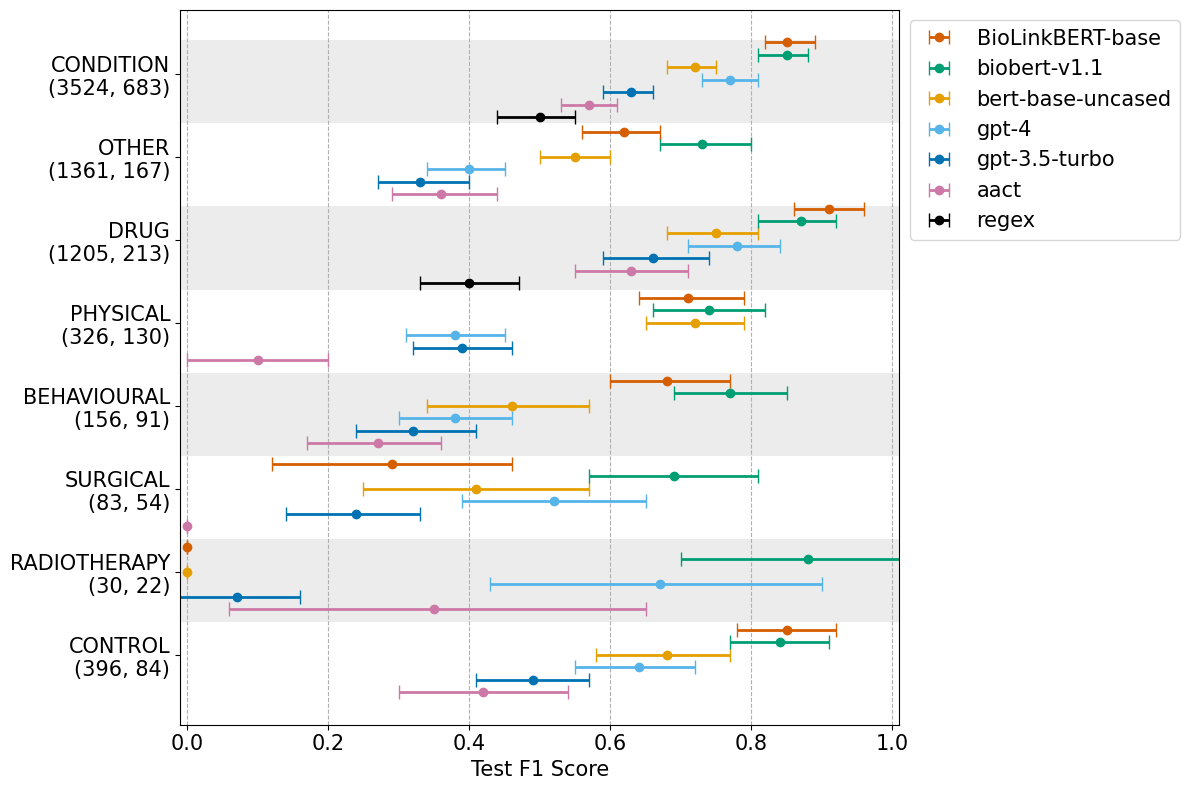

In [1065]:
# color palette: https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
colors = {
    'BioLinkBERT-base': '#D55E00',                    
    'biobert-v1.1': '#009E73',            
    'bert-base-uncased': '#E69F00',       
    'gpt-3.5-turbo': '#0072B2',           
    'gpt-4': '#56B4E9',                   
    'aact': '#CC79A7',        
    'regex': '#000000'
    
}

results = formatted_partial_matches_f1

# Predefined order of entity types
entity_order = ['condition', 'other', 'drug', 'physical', 'behavioural', 'surgical', 'radiotherapy', 'control']

fig, ax = plt.subplots(figsize=(12, 8))
model_spacing = 0.15  # Spacing between models within the same entity type
entity_spacing = 0.5  # Additional spacing between different entity types

# Iterate over each entity type in the predefined order
for i, entity_type in enumerate(entity_order[::-1]):
    model_index = 0  # Reset model index for each entity type
    if entity_type in results:
        num_models = len(results[entity_type])
        for model_name, data in results[entity_type].items():
            center = data[0][1]
            lower, upper = data[0][0], data[0][2]
            #model_name = model_name.split("_")[1]
            color = colors[model_name]
            
            # Plot
            y_position = i + (model_index - num_models / 2) * model_spacing
            ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]], elinewidth = 2, fmt='o', color=color, capsize=5, label=model_name )#if i == 0 else "")
            #if center == 0: 
            #    ax.text(center, y_position, f"{center:.0f}", ha='center', va='bottom')
            #else:
            #    ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
            model_index += 1  
            
# Setting the y-ticks according to the new entity order
ax.set_yticks(np.arange(len(entity_order)))
ax.set_yticklabels(entity_labels[::-1], fontsize=15)

ax.set_xlabel('Test F1 Score', fontsize=15)
#ax.set_title('Performance by Entity Type (entity frequency in test, frequency in train)', fontsize=14)
ax.grid(True, axis='x', linestyle='--',)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlim([-0.01, 1.01])

alt_bands_y_axis(ax)

# Creating a legend that doesn't repeat labels
handles, labels = plt.gca().get_legend_handles_labels()
#print(labels)
# Add 'regex' to the legend
#handles.append(ax.errorbar(0, 0, xerr=[[0], [0]], color=colors['regex'], fmt='o', elinewidth = 3, capsize=5, label='regex'))
#labels.append('regex')
# Reverse handles and labels
handles = handles [::-1]
labels = labels [::-1]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=15, bbox_to_anchor=(1, 1))

#ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig("./evaluations/plots/rebuttal_all_entities_performance_v153_test.pdf")
plt.show()

## Micro and Macro averages

In [909]:
annotations_df_final.head(2)

,Unnamed: 0,nct_id,unique_condition_regex,unique_drug_regex,unique_condition_target,unique_drug_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,...,target_drug_annotations_partial_gpt-4,predicted_drug_annotations_partial_gpt-4,target_drug_annotations_exact_gpt-3.5-turbo,predicted_drug_annotations_exact_gpt-3.5-turbo,target_drug_annotations_partial_gpt-3.5-turbo,predicted_drug_annotations_partial_gpt-3.5-turbo,target_drug_v2_annotations_exact_gpt-4,predicted_drug_v2_annotations_exact_gpt-4,target_drug_v2_annotations_partial_gpt-4,predicted_drug_v2_annotations_partial_gpt-4
0,0,NCT04045665,NaN,NaN,coronary artery bypass graft|isolated coronary...,anticoagulants|anticoagulation|antiplatelet th...,NaN,NaN,NaN,NaN,...,"[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
1,1,NCT02311036,NaN,NaN,-cerebrovascular diseases,NaN,NaN,comprehensive rehabilitation,NaN,NaN,...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]


In [645]:
from scipy.stats import bootstrap
import numpy as np
from typing import List, Callable, Optional, Tuple

bootstrap_methods = [
    'bootstrap_bca',
    'bootstrap_percentile',
    'bootstrap_basic']


class BootstrapParams:
    n_resamples: int
    random_state: Optional[np.random.RandomState]


def bootstrap_ci(y_true: List[int],
                 y_pred: List[int],
                 metric: Callable,
                 metric_average: str = 'n.a.',
                 confidence_level: float = 0.95,
                 n_resamples: int = 9999,
                 method: str = 'bootstrap_bca',
                 random_state: Optional[np.random.RandomState] = None) -> Tuple[float, Tuple[float, float]]:

    def statistic(*indices):
        indices = np.array(indices)[0, :]
        if metric_average != 'n.a.':
            return metric(np.array(y_true)[indices], np.array(y_pred)[indices], average=metric_average, zero_division=np.nan)
        return metric(np.array(y_true)[indices], np.array(y_pred)[indices])

    assert method in bootstrap_methods, f'Bootstrap ci method {method} not in {bootstrap_methods}'

    indices = (np.arange(len(y_true)), )
    bootstrap_res = bootstrap(indices,
                              statistic=statistic,
                              n_resamples=n_resamples,
                              confidence_level=confidence_level,
                              method=method.split('bootstrap_')[1],
                              random_state=random_state)
    if metric_average != 'n.a.':
        result = metric(y_true, y_pred, average=metric_average, zero_division=np.nan)
    else:
        result = metric(y_true, y_pred)
    ci = bootstrap_res.confidence_interval.low, bootstrap_res.confidence_interval.high
    return result, ci

In [929]:
def calculate_average_f1_scores(annotations_df, entities, model, round_to=2):
    exact_matches = {"micro": {}, "macro": {}, "weighted": {}}
    partial_matches = {"micro": {}, "macro": {}, "weighted": {}}

    all_entity_target_exact = []
    all_entity_predictions_exact = []
    all_entity_target_partial = []
    all_entity_predictions_partial = []

    # Collect the annotations from all entities into a single array
    for entity in entities:
        if (entity != 'condition' and entity != 'drug') and 'regex' in model:
           continue  
        try:
             # Check if all columns are present in the DataFrame
            # Columns to check
            columns_to_check = [f'target_{entity}_annotations_exact_{model}',
                                f'predicted_{entity}_annotations_exact_{model}',
                                f'target_{entity}_annotations_partial_{model}',
                                f'predicted_{entity}_annotations_partial_{model}']
            
            # Check if all columns are present in the DataFrame
            missing_columns = [col for col in columns_to_check if col not in annotations_df.columns]
            if not missing_columns:
                flattened_data_target_exact = flatten_column_arrays(annotations_df.get(f'target_{entity}_annotations_exact_{model}', pd.Series()))
                flattened_data_model_exact = flatten_column_arrays(annotations_df.get(f'predicted_{entity}_annotations_exact_{model}', pd.Series()))
                flattened_data_target_partial = flatten_column_arrays(annotations_df.get(f'target_{entity}_annotations_partial_{model}', pd.Series()))
                flattened_data_model_partial = flatten_column_arrays(annotations_df.get(f'predicted_{entity}_annotations_partial_{model}', pd.Series()))      
            else:
                # Handle the case where one or more columns are missing
                print("The following required columns are missing in the DataFrame:")
                for col in missing_columns:
                    print(col)
            #print(flattened_data_target_exact)
            all_entity_target_exact.append(flattened_data_target_exact)
            all_entity_predictions_exact.append(flattened_data_model_exact)
            all_entity_target_partial.append(flattened_data_target_partial)
            all_entity_predictions_partial.append(flattened_data_model_partial)
        except Exception as e:
            print(f"An error occurred for {model} in {entity}: {e}")
        
    #print(all_entity_target_exact)
    #print(f"Array size exact {len(all_entity_target_exact)} and {len(all_entity_predictions_exact)}")
    #print(f"Array size partial {len(all_entity_target_partial)} and {len(all_entity_predictions_partial)}")

    all_entity_target_exact = np.concatenate(all_entity_target_exact, axis=0)
    all_entity_predictions_exact = np.concatenate(all_entity_predictions_exact, axis=0)
    all_entity_target_partial = np.concatenate(all_entity_target_partial, axis=0)
    all_entity_predictions_partial = np.concatenate(all_entity_predictions_partial, axis=0)

    print(f"Array size exact {len(all_entity_target_exact)} and {len(all_entity_predictions_exact)}")
    print(f"Array size partial {len(all_entity_target_partial)} and {len(all_entity_predictions_partial)}")
    #print("Micro sklearn exact", sklearn.metrics.f1_score(all_entity_target_exact,all_entity_predictions_exact, average='micro')) 
    #print("Macro sklearn exact", sklearn.metrics.f1_score(all_entity_target_exact,all_entity_predictions_exact, average='macro')) 

    # Calculate and store F1 scores
    print("Calculating F1 scores over all entities...")
    exact_f1_micro = f1_score(all_entity_target_exact, all_entity_predictions_exact, average='micro')
    partial_f1_micro = f1_score(all_entity_target_partial, all_entity_predictions_partial, average='micro')

    random_generator = np.random.default_rng()
    exact_f1_weighted = bootstrap_ci(y_true=all_entity_target_exact,
                                         y_pred=all_entity_predictions_exact,
                                         metric=sklearn.metrics.f1_score,
                                         metric_average='weighted',
                                         confidence_level=0.95,
                                         n_resamples=9999,
                                         method='bootstrap_bca',
                                         random_state=random_generator)
    partial_f1_weighted = bootstrap_ci(y_true=all_entity_target_partial,
                                         y_pred=all_entity_predictions_partial,
                                         metric=sklearn.metrics.f1_score,
                                         metric_average='weighted',
                                         confidence_level=0.95,
                                         n_resamples=9999,
                                         method='bootstrap_bca',
                                         random_state=random_generator)

    exact_f1_macro = f1_score(all_entity_target_exact, all_entity_predictions_exact, average='macro')
    partial_f1_macro = f1_score(all_entity_target_partial, all_entity_predictions_partial, average='macro')
    

    exact_matches["micro"]["exact"] = round_tuple(exact_f1_micro,round_to)
    exact_matches["macro"]["exact"] = round_tuple(exact_f1_macro,round_to)
    exact_matches["weighted"]["exact"] = round_tuple(exact_f1_weighted,round_to)


    partial_matches["micro"]["partial"] = round_tuple(partial_f1_micro,round_to)
    partial_matches["macro"]["partial"] = round_tuple(partial_f1_macro,round_to)
    partial_matches["weighted"]["partial"] = round_tuple(partial_f1_weighted,round_to)

    print("Calculating classification reports...")
    cp_exact = classification_report_with_ci(all_entity_target_exact,all_entity_predictions_exact)
    cp_partial = classification_report_with_ci(all_entity_target_partial,all_entity_predictions_partial)

    return exact_matches, partial_matches, cp_exact, cp_partial

### Map the entity columns to different numerical representations

In [930]:
entity_map_to_numerical = {
    'condition': 1,
    'other': 2,
    'drug': 3,
    'physical': 4,
    'behavioural': 5,
    'surgical': 6,
    'radiotherapy': 7,
    'control': 8
}

In [931]:
annotations_df_final_ = annotations_df_final.copy()

In [932]:
# Iterate over columns
for column in annotations_df_final_.columns:
    for entity, number in entity_map_to_numerical.items():
        if f'{entity}_annotations' in column:
            #print(f"setting {column} to numerical")
            annotations_df_final_[column] = annotations_df_final_[column].apply(lambda x: [number if val == 1 else val for val in ast.literal_eval(x)])


In [933]:
columns_to_keep = ['nct_id'] + [column for column in annotations_df_final_.columns if any(f'{entity}_annotations' in column for entity in entity_map_to_numerical)]

annotations_df_final_[columns_to_keep].head()

,nct_id,target_condition_annotations_exact_BioLinkBERT-base,predicted_condition_annotations_exact_BioLinkBERT-base,target_condition_annotations_partial_BioLinkBERT-base,predicted_condition_annotations_partial_BioLinkBERT-base,target_condition_annotations_exact_biobert-v1.1,predicted_condition_annotations_exact_biobert-v1.1,target_condition_annotations_partial_biobert-v1.1,predicted_condition_annotations_partial_biobert-v1.1,target_condition_annotations_exact_bert-base-uncased,...,target_condition_annotations_partial_gpt-3.5-turbo,predicted_condition_annotations_partial_gpt-3.5-turbo,target_drug_annotations_exact_gpt-4,predicted_drug_annotations_exact_gpt-4,target_drug_annotations_partial_gpt-4,predicted_drug_annotations_partial_gpt-4,target_drug_annotations_exact_gpt-3.5-turbo,predicted_drug_annotations_exact_gpt-3.5-turbo,target_drug_annotations_partial_gpt-3.5-turbo,predicted_drug_annotations_partial_gpt-3.5-turbo
0,NCT04045665,"[1, 0, 1, 1, 1, 0]","[1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 0]","[1, 0, 0, 1, 1, 1, 0]","[1, 1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 1, 1, 1, 0]","[0, 1, 0, 0, 1, 1, 1]",...,"[1, 0, 0, 1, 1, 1, 1]","[1, 1, 1, 0, 1, 0, 1]","[3, 3, 3, 3, 3, 0]","[3, 0, 3, 3, 0, 3]","[3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[0, 0, 0, 0, 0]","[3, 3, 3, 3, 3]","[0, 0, 0, 0, 0]"
1,NCT02311036,"[1, 0]","[0, 1]","[1, 1]","[1, 1]","[1, 0]","[0, 1]","[1, 1]","[1, 1]","[1, 0]",...,"[1, 1, 1]","[1, 0, 1]",[0],[0],[0],[0],[0],[0],[0],[0]
2,NCT05369793,"[1, 1]","[1, 1]","[1, 1]","[1, 1]","[1, 1]","[1, 1]","[1, 1]","[1, 1]","[1, 1]",...,"[1, 1, 1]","[1, 1, 1]",[3],[3],[3],[3],[3],[3],[3],[3]
3,NCT04483310,"[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1, 0]",...,"[1, 1, 1]","[1, 1, 1]",[0],[0],[0],[0],[0],[0],[0],[0]
4,NCT01418976,"[1, 1, 0]","[1, 1, 1]","[1, 1, 1]","[1, 1, 0]","[0, 1, 0, 1, 0, 0, 0]","[1, 1, 1, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[0, 1, 0, 1, 1, 0, 1]","[0, 1, 0, 1]",...,"[1, 1, 1, 1, 1]","[0, 0, 1, 1, 0]",[0],[0],[0],[0],[0],[0],[0],[0]


In [934]:
entities = ['condition','other','drug','physical','behavioural','surgical','radiotherapy','control']

In [935]:
models = ['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased', 'gpt-4', 'gpt-3.5-turbo', 'aact','regex']
res_exact, res_partial, report_exact, report_partial = calculate_average_f1_scores(annotations_df_final_, entities, 'BioLinkBERT-base', round_to=2)
res_exact, res_partial

Array size exact 2055 and 2055
Array size partial 2055 and 2055
Calculating F1 scores over all entities...
Calculating classification reports...


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

({'micro': {'exact': (0.66, (0.64, 0.68))},
  'macro': {'exact': (0.47, (0.45, 0.48))},
  'weighted': {'exact': (0.66, (0.64, 0.68))}},
 {'micro': {'partial': (0.77, (0.75, 0.79))},
  'macro': {'partial': (0.63, (0.61, 0.65))},
  'weighted': {'partial': (0.77, (0.75, 0.79))}})

In [922]:
res_exact, res_partial, report_exact_aact, report_partial_aact = calculate_average_f1_scores(annotations_df_final_, entities, 'aact', round_to=2)
res_exact, res_partial

Array size exact 2123 and 2123
Array size partial 2123 and 2123


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

({'micro': {'exact': (0.44, (0.42, 0.46))},
  'macro': {'exact': (0.2, (0.18, 0.22))},
  'weighted': {'exact': (0.43, (0.4, 0.45))}},
 {'micro': {'partial': (0.56, (0.54, 0.59))},
  'macro': {'partial': (0.37, (0.35, 0.39))},
  'weighted': {'partial': (0.56, (0.54, 0.58))}})

In [923]:
res_exact, res_partial, report_exact_gpt4, report_partial_gpt4 = calculate_average_f1_scores(annotations_df_final_, entities, 'gpt-4', round_to=2)
res_exact, res_partial

Array size exact 2244 and 2244
Array size partial 2244 and 2244


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


({'micro': {'exact': (0.42, (0.4, 0.44))},
  'macro': {'exact': (0.3, (0.28, 0.32))},
  'weighted': {'exact': (0.45, (0.43, 0.47))}},
 {'micro': {'partial': (0.56, (0.54, 0.58))},
  'macro': {'partial': (0.57, (0.55, 0.58))},
  'weighted': {'partial': (0.57, (0.55, 0.59))}})

In [936]:
report_partial_aact

,Class,Precision,Recall,F1-Score,Precision CI,Recall CI,F1-Score CI,Support
0,Class 0,0.628,0.625,0.627,"(0.601, 0.655)","(0.598, 0.652)","(0.604, 0.649)",1240
1,Class 1,0.588,0.556,0.572,"(0.542, 0.633)","(0.511, 0.6)","(0.533, 0.61)",473
2,Class 2,0.289,0.485,0.362,"(0.226, 0.362)","(0.389, 0.582)","(0.288, 0.437)",99
3,Class 3,0.556,0.730,0.631,"(0.465, 0.642)","(0.63, 0.812)","(0.554, 0.708)",89
4,Class 4,0.400,0.058,0.101,"(0.168, 0.687)","(0.023, 0.14)","(0.009, 0.194)",69
5,Class 5,0.194,0.426,0.267,"(0.129, 0.281)","(0.295, 0.567)","(0.173, 0.36)",47
6,Class 6,0.000,0.000,0.000,"(nan, nan)","(0.0, 0.099)","(0.0, 0.0)",35
7,Class 7,0.333,0.375,0.353,"(0.121, 0.646)","(0.137, 0.694)","(0.061, 0.645)",8
8,Class 8,0.568,0.333,0.420,"(0.409, 0.713)","(0.229, 0.456)","(0.298, 0.542)",63
9,micro,0.565,0.565,0.565,"(0.544, 0.586)","(0.544, 0.586)","(0.544, 0.586)",2123


In [937]:
report_partial_gpt4

,Class,Precision,Recall,F1-Score,Precision CI,Recall CI,F1-Score CI,Support
0,Class 0,0.741,0.437,0.550,"(0.709, 0.77)","(0.411, 0.463)","(0.525, 0.575)",1373
1,Class 1,0.716,0.838,0.772,"(0.669, 0.759)","(0.795, 0.874)","(0.737, 0.808)",328
2,Class 2,0.281,0.678,0.397,"(0.237, 0.329)","(0.599, 0.748)","(0.343, 0.451)",149
3,Class 3,0.721,0.845,0.778,"(0.638, 0.791)","(0.766, 0.901)","(0.719, 0.837)",110
4,Class 4,0.268,0.646,0.379,"(0.216, 0.327)","(0.548, 0.734)","(0.312, 0.445)",99
5,Class 5,0.275,0.629,0.383,"(0.212, 0.349)","(0.511, 0.732)","(0.302, 0.463)",70
6,Class 6,0.415,0.710,0.524,"(0.293, 0.549)","(0.534, 0.839)","(0.394, 0.654)",31
7,Class 7,0.700,0.636,0.667,"(0.397, 0.892)","(0.354, 0.848)","(0.434, 0.9)",11
8,Class 8,0.556,0.753,0.640,"(0.457, 0.65)","(0.644, 0.838)","(0.556, 0.723)",73
9,micro,0.562,0.562,0.562,"(0.541, 0.582)","(0.541, 0.582)","(0.541, 0.582)",2244


In [654]:
# Initialize an empty DataFrame to store results
combined_results = pd.DataFrame()

# Iterate over the models
for model in models:
    print(model)
    # Calculate F1 scores for the current model
    res_exact, res_partial, report_exact, report_partial = calculate_average_f1_scores(annotations_df_final_, entities, model, round_to=2)
    # Convert the result dictionary into a DataFrame
    res_df = pd.DataFrame((res_exact, res_partial))
    # Add a column for the model name
    res_df['model'] = model
    # Concatenate the results to the combined DataFrame
    combined_results = pd.concat([combined_results, res_df], ignore_index=True)


BioLinkBERT-base


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

biobert-v1.1
bert-base-uncased


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

gpt-4


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


gpt-3.5-turbo


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


aact


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

regex


In [838]:
combined_results.reset_index().set_index('model').T


model,BioLinkBERT-base,BioLinkBERT-base,biobert-v1.1,biobert-v1.1,bert-base-uncased,bert-base-uncased,gpt-4,gpt-4,gpt-3.5-turbo,gpt-3.5-turbo,aact,aact,regex,regex
index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
micro,"{'exact': (0.66, (0.64, 0.68))}","{'partial': (0.77, (0.75, 0.79))}","{'exact': (0.68, (0.66, 0.7))}","{'partial': (0.81, (0.79, 0.83))}","{'exact': (0.54, (0.52, 0.56))}","{'partial': (0.67, (0.65, 0.69))}","{'exact': (0.42, (0.4, 0.44))}","{'partial': (0.56, (0.54, 0.58))}","{'exact': (0.35, (0.33, 0.37))}","{'partial': (0.47, (0.45, 0.49))}","{'exact': (0.44, (0.42, 0.46))}","{'partial': (0.56, (0.54, 0.59))}","{'exact': (0.25, (0.22, 0.29))}","{'partial': (0.34, (0.31, 0.38))}"
macro,"{'exact': (0.47, (0.45, 0.48))}","{'partial': (0.63, (0.61, 0.65))}","{'exact': (0.6, (0.58, 0.62))}","{'partial': (0.8, (0.78, 0.81))}","{'exact': (0.31, (0.29, 0.33))}","{'partial': (0.55, (0.53, 0.57))}","{'exact': (0.3, (0.28, 0.32))}","{'partial': (0.57, (0.55, 0.58))}","{'exact': (0.23, (0.21, 0.25))}","{'partial': (0.4, (0.38, 0.42))}","{'exact': (0.2, (0.18, 0.22))}","{'partial': (0.37, (0.35, 0.39))}","{'exact': (0.2, (0.16, 0.25))}","{'partial': (0.26, (0.22, 0.31))}"
weighted,"{'exact': (0.66, (0.64, 0.68))}","{'partial': (0.77, (0.75, 0.79))}","{'exact': (0.68, (0.66, 0.7))}","{'partial': (0.81, (0.79, 0.83))}","{'exact': (0.54, (0.52, 0.56))}","{'partial': (0.67, (0.65, 0.69))}","{'exact': (0.45, (0.43, 0.47))}","{'partial': (0.57, (0.55, 0.59))}","{'exact': (0.38, (0.36, 0.4))}","{'partial': (0.49, (0.47, 0.51))}","{'exact': (0.43, (0.41, 0.45))}","{'partial': (0.56, (0.54, 0.58))}","{'exact': (0.27, (0.24, 0.31))}","{'partial': (0.33, (0.3, 0.37))}"


# Evaluation library demo

In [19]:
import sklearn.metrics #import precision_score, recall_score, f1_score

# Example data
true_labels = [1]*90 + [0]*80 + [1]*20 + [0]*10  # True labels (90 TP, 20 FN, 80 TN, 10 FP)
predicted_labels = [1]*100 + [0]*100          # Predicted labels (90 TP, 10 FP, 80 TN, 20 FN)

# Calculate Precision
precision = sklearn.metrics.precision_score(true_labels, predicted_labels)

# Calculate Recall
recall = sklearn.metrics.recall_score(true_labels, predicted_labels)

# Calculate F1 Score
f1 = sklearn.metrics.f1_score(true_labels, predicted_labels)

precision, recall, f1

(0.9, 0.8181818181818182, 0.8571428571428571)

In [ ]:
binary_method = 'wilson'
from confidenceinterval import precision_score, recall_score, f1_score

precision_score(true_labels, predicted_labels, average='binary', method=binary_method)[0], recall_score(true_labels, predicted_labels, average='binary', method=binary_method)[0], f1_score(true_labels, predicted_labels)[0]

In [200]:
import difflib


In [207]:
target = "binaural stimulation|virtual content"
predicted = "binaural audio|binaural stimulation|multi-sensory conditions in virtual reality|virtual environments|virtual reality"


predicted_terms = predicted.split('|')
target_terms = target.split('|')
matches = []
for pred in predicted_terms:
    # Use difflib to find close matches, with a cutoff for match quality
    match_found = any(difflib.get_close_matches(pred, target_terms, n=1, cutoff=0.6))
    print(pred, match_found, difflib.get_close_matches(pred, target_terms, n=1, cutoff=0.6))
    matches.append(match_found)

matches

binaural audio True ['binaural stimulation']
binaural stimulation True ['binaural stimulation']
multi-sensory conditions in virtual reality False []
virtual environments True ['virtual content']
virtual reality True ['virtual content']


[True, True, False, True, True]

# Token level evaluation

In [ ]:
from datasets import load_dataset


In [ ]:
entity_numerical_to_map = {
    0: 'no-entity',
    1: 'condition',
    2: 'other',
    3: 'drug',
    4: 'physical',
    5: 'behavioural',
    6: 'surgical',
    7: 'radiotherapy',
    8: 'control'
}

In [ ]:
entity_map_to_numerical = {
    'COND': 1,
    'OTHER': 2,
    'DRUG': 3,
    'PHYS': 4,
    'BEH': 5,
    'SURG': 6,
    'RADIO': 7,
    'CTRL': 8
}

In [707]:
path_to_bert_base = "./predictions/rebuttal/bert/ct_neuro_test_annotated_bert-base-uncased_BIO_20240529.csv"
path_to_biobert = "./predictions/rebuttal/bert/ct_neuro_test_annotated_biobert-v1.1_BIO_20240529.csv"
path_to_biolinkbert = "./predictions/rebuttal/bert/ct_neuro_test_annotated_BioLinkBERT-base_BIO_20240529.csv"


In [803]:
df_bert_base = pd.read_csv(path_to_bert_base)[['nct_id', 'tokens', 'ner_tags', 'labels', 'predictions_bert-base-uncased']]
df_biobert = pd.read_csv(path_to_biobert)[['nct_id','tokens','ner_tags', 'labels', 'predictions_biobert-v1.1']]
df_biolinkbert = pd.read_csv(path_to_biolinkbert)[['nct_id','tokens','ner_tags', 'labels', 'predictions_BioLinkBERT-base']]

In [ ]:
def get_label_list(labels):
    print("*** returning unique labels ***")
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    print(label_list)
    return label_list)

train_file_name = "../data/annotated_data/data_splits/stratified_entities/ct_neuro_train_data_787.json"
    
data_files = {"train": train_file_name}
raw_datasets = load_dataset("json", data_files=data_files)

In [797]:
label_list = get_label_list(raw_datasets["train"]["ner_tags"])


*** returning unique labels ***


In [798]:
def convert_to_list(string):
    string = string.strip('[]')  # Remove the brackets
    return list(map(int, string.split()))

def replace_with_numerical(x, entity_map_to_numerical):
    mapped_array = []
    for tag in x:
        if tag != "O":
            mapped_array.append(str(entity_map_to_numerical[tag.split("-")[1]]))
        else:
            mapped_array.append(tag)
    if len(x) != len(mapped_array):
        print("Incorrect mapping for ", x)
    return mapped_array

def convert_to_int_list(data):
    int_list = []
    for sublist in data:
        for item in sublist:
            if item == 'O':
                int_list.append(0)
            else:
                int_list.append(int(item))
    return int_list

In [826]:
def format_classification_report(summary_df):
    summary_df.columns = [col.lower() for col in summary_df.columns]

    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision ci'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall ci'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score ci'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision ci', 'recall', 'recall ci', 'f1-score', 'f1-score ci'], inplace=True)
    return summary_df

In [868]:
def process_bio_and_get_classification_report(df, model_name, label_list, entity_map_to_numerical):
    predicted_labels_column = "predictions_" + model_name
    target_labels_column = "labels"
    
    predictions = np.array(df[predicted_labels_column].apply(convert_to_list).to_list())
    labels = np.array(df[target_labels_column].apply(convert_to_list).to_list())
    print("labels ", len(labels))

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    predictions_mapped = [replace_with_numerical(x, entity_map_to_numerical) for x in true_predictions]
    target_labels_mapped = [replace_with_numerical(x, entity_map_to_numerical) for x in true_labels]

    predictions_list = [item for sublist in predictions_mapped for item in sublist]
    targets_list = [item for sublist in target_labels_mapped for item in sublist]
    
    predictions_list = convert_to_int_list(predictions_mapped)
    targets_list = convert_to_int_list(target_labels_mapped)
    len(predictions_list), len(targets_list)

    print("targets_list ", len(targets_list))

    classification_report = classification_report_with_ci(targets_list, predictions_list, numerical_to_label_map = entity_numerical_to_map, round_ndigits=2)

    return format_classification_report(classification_report)

In [869]:
df_bert_entity_report = process_bio_and_get_classification_report(df_bert_base, 'bert-base-uncased', label_list, entity_map_to_numerical)
df_bert_entity_report = df_bert_entity_report[['class','F1-Score (CI)']].rename(columns={'F1-Score (CI)':'bert-base-uncased'})

labels  153
targets_list  20015


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

In [870]:
df_bert_entity_report

,class,bert-base-uncased
0,no-entity,"0.97 (0.97, 0.98)"
1,condition,"0.85 (0.83, 0.86)"
2,other,"0.52 (0.49, 0.56)"
3,drug,"0.85 (0.81, 0.88)"
4,physical,"0.69 (0.65, 0.72)"
5,behavioural,"0.36 (0.3, 0.43)"
6,surgical,"0.3 (0.22, 0.37)"
7,radiotherapy,"0.0 (0.0, 0.0)"
8,control,"0.33 (0.25, 0.41)"
9,micro,"0.93 (0.92, 0.93)"


In [871]:
df_biobert_entity_report = process_bio_and_get_confusion_matrix(df_biobert, 'biobert-v1.1', label_list, entity_map_to_numerical)
df_biobert_entity_report = df_biobert_entity_report[['class','F1-Score (CI)']].rename(columns={'F1-Score (CI)':'biobert-v1.1'})
df_biobert_entity_report

labels  153
targets_list  19866


,class,biobert-v1.1
0,no-entity,"0.98 (0.97, 0.98)"
1,condition,"0.88 (0.87, 0.89)"
2,other,"0.66 (0.62, 0.69)"
3,drug,"0.85 (0.82, 0.88)"
4,physical,"0.77 (0.74, 0.8)"
5,behavioural,"0.72 (0.67, 0.76)"
6,surgical,"0.74 (0.69, 0.79)"
7,radiotherapy,"0.93 (0.87, 0.99)"
8,control,"0.75 (0.71, 0.8)"
9,micro,"0.95 (0.95, 0.95)"


In [872]:
df_biolink_entity_report = process_bio_and_get_confusion_matrix(df_biolinkbert, 'BioLinkBERT-base', label_list, entity_map_to_numerical)
df_biolink_entity_report = df_biolink_entity_report[['class','F1-Score (CI)']].rename(columns={'F1-Score (CI)':'BioLinkBERT-base'})
df_biolink_entity_report

labels  153
targets_list  20179


/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.

,class,BioLinkBERT-base
0,no-entity,"0.98 (0.98, 0.98)"
1,condition,"0.89 (0.88, 0.9)"
2,other,"0.59 (0.56, 0.62)"
3,drug,"0.9 (0.88, 0.93)"
4,physical,"0.7 (0.66, 0.73)"
5,behavioural,"0.64 (0.59, 0.69)"
6,surgical,"0.31 (0.24, 0.39)"
7,radiotherapy,"0.0 (0.0, 0.0)"
8,control,"0.79 (0.75, 0.84)"
9,micro,"0.94 (0.94, 0.95)"


In [873]:
df_bert_entity_report, df_biobert_entity_report, df_biolink_entity_report

(           class  bert-base-uncased
 0      no-entity  0.97 (0.97, 0.98)
 1      condition  0.85 (0.83, 0.86)
 2          other  0.52 (0.49, 0.56)
 3           drug  0.85 (0.81, 0.88)
 4       physical  0.69 (0.65, 0.72)
 5    behavioural   0.36 (0.3, 0.43)
 6       surgical   0.3 (0.22, 0.37)
 7   radiotherapy     0.0 (0.0, 0.0)
 8        control  0.33 (0.25, 0.41)
 9          micro  0.93 (0.92, 0.93)
 10         macro  0.54 (0.53, 0.55),
            class       biobert-v1.1
 0      no-entity  0.98 (0.97, 0.98)
 1      condition  0.88 (0.87, 0.89)
 2          other  0.66 (0.62, 0.69)
 3           drug  0.85 (0.82, 0.88)
 4       physical   0.77 (0.74, 0.8)
 5    behavioural  0.72 (0.67, 0.76)
 6       surgical  0.74 (0.69, 0.79)
 7   radiotherapy  0.93 (0.87, 0.99)
 8        control   0.75 (0.71, 0.8)
 9          micro  0.95 (0.95, 0.95)
 10         macro   0.81 (0.8, 0.81),
            class   BioLinkBERT-base
 0      no-entity  0.98 (0.98, 0.98)
 1      condition   0.89 (0.88, 0.9)

In [874]:
df_linkbert_biobert = pd.merge(df_biolink_entity_report, df_biobert_entity_report, on='class', how='left')
df_linkbert_biobert_bert = pd.merge(df_linkbert_biobert, df_bert_entity_report, on='class', how='left')

excl_macro = df_linkbert_biobert_bert[~(df_linkbert_biobert_bert['class'] == "macro")]
final_entity = excl_macro[~(excl_macro['class'] == "no-entity")]
final_entity = final_entity.rename(columns={'class':'Entity Type'})
final_entity['Entity Type'] = final_entity['Entity Type'].str.upper()

final_entity

,Entity Type,BioLinkBERT-base,biobert-v1.1,bert-base-uncased
1,CONDITION,"0.89 (0.88, 0.9)","0.88 (0.87, 0.89)","0.85 (0.83, 0.86)"
2,OTHER,"0.59 (0.56, 0.62)","0.66 (0.62, 0.69)","0.52 (0.49, 0.56)"
3,DRUG,"0.9 (0.88, 0.93)","0.85 (0.82, 0.88)","0.85 (0.81, 0.88)"
4,PHYSICAL,"0.7 (0.66, 0.73)","0.77 (0.74, 0.8)","0.69 (0.65, 0.72)"
5,BEHAVIOURAL,"0.64 (0.59, 0.69)","0.72 (0.67, 0.76)","0.36 (0.3, 0.43)"
6,SURGICAL,"0.31 (0.24, 0.39)","0.74 (0.69, 0.79)","0.3 (0.22, 0.37)"
7,RADIOTHERAPY,"0.0 (0.0, 0.0)","0.93 (0.87, 0.99)","0.0 (0.0, 0.0)"
8,CONTROL,"0.79 (0.75, 0.84)","0.75 (0.71, 0.8)","0.33 (0.25, 0.41)"
9,MICRO,"0.94 (0.94, 0.95)","0.95 (0.95, 0.95)","0.93 (0.92, 0.93)"


In [875]:
print(final_entity.to_latex(float_format="%.2f", index=False))

\begin{tabular}{llll}
\toprule
Entity Type & BioLinkBERT-base & biobert-v1.1 & bert-base-uncased \\
\midrule
CONDITION & 0.89 (0.88, 0.9) & 0.88 (0.87, 0.89) & 0.85 (0.83, 0.86) \\
OTHER & 0.59 (0.56, 0.62) & 0.66 (0.62, 0.69) & 0.52 (0.49, 0.56) \\
DRUG & 0.9 (0.88, 0.93) & 0.85 (0.82, 0.88) & 0.85 (0.81, 0.88) \\
PHYSICAL & 0.7 (0.66, 0.73) & 0.77 (0.74, 0.8) & 0.69 (0.65, 0.72) \\
BEHAVIOURAL & 0.64 (0.59, 0.69) & 0.72 (0.67, 0.76) & 0.36 (0.3, 0.43) \\
SURGICAL & 0.31 (0.24, 0.39) & 0.74 (0.69, 0.79) & 0.3 (0.22, 0.37) \\
RADIOTHERAPY & 0.0 (0.0, 0.0) & 0.93 (0.87, 0.99) & 0.0 (0.0, 0.0) \\
CONTROL & 0.79 (0.75, 0.84) & 0.75 (0.71, 0.8) & 0.33 (0.25, 0.41) \\
MICRO & 0.94 (0.94, 0.95) & 0.95 (0.95, 0.95) & 0.93 (0.92, 0.93) \\
\bottomrule
\end{tabular}

